In [61]:
import extract
import pandas as pd
import os
import geopandas as gpd

In [62]:
import importlib
importlib.reload(extract)

<module 'extract' from '/Users/kguan17/Documents/GitHub/RA-Work/acs/extract.py'>

In [63]:
# open old_elections.xlsx and new_elections.xlsx and combine (they have the same columns)
old_elections = pd.read_excel("old_elections.xlsx")
new_elections = pd.read_excel("new_elections.xlsx")
elections = pd.concat([old_elections, new_elections])
# reset index
elections.reset_index(drop=True, inplace=True)

elections[140:150]

,filename,city,state,Geography,District #,office,year,geo_filename
140,NewYorkCity_06222021_CONCouncilMember19thCounc...,New York,NY,city council,18,City council,2021,new_york_city_council_2021.csv
141,NewYorkCity_06222021_DEMCouncilMember10thCounc...,New York,NY,city council,10,City council,2021,new_york_city_council_2021.csv
142,NewYorkCity_06222021_DEMCouncilMember11thCounc...,New York,NY,city council,11,City council,2021,new_york_city_council_2021.csv
143,NewYorkCity_06222021_DEMCouncilMember12thCounc...,New York,NY,city council,12,City council,2021,new_york_city_council_2021.csv
144,NewYorkCity_06222021_DEMCouncilMember13thCounc...,New York,NY,city council,13,City council,2021,new_york_city_council_2021.csv
145,NewYorkCity_06222021_DEMCouncilMember14thCounc...,New York,NY,city council,14,City council,2021,new_york_city_council_2021.csv
146,NewYorkCity_06222021_DEMCouncilMember15thCounc...,New York,NY,city council,15,City council,2021,new_york_city_council_2021.csv
147,NewYorkCity_06222021_DEMCouncilMember16thCounc...,New York,NY,city council,16,City council,2021,new_york_city_council_2021.csv
148,NewYorkCity_06222021_DEMCouncilMember17thCounc...,New York,NY,city council,17,City council,2021,new_york_city_council_2021.csv
149,NewYorkCity_06222021_DEMCouncilMember18thCounc...,New York,NY,city council,18,City council,2021,new_york_city_council_2021.csv


In [64]:
# add tracts and percents columns to elections
elections['tracts'] = None
elections['percents'] = None

In [65]:
abbreviation_to_name = {
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC": "District of Columbia",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Inhabited_territories.
    "AS": "American Samoa",
    "GU": "Guam GU",
    "MP": "Northern Mariana Islands",
    "PR": "Puerto Rico PR",
    "VI": "U.S. Virgin Islands",
}

In [72]:
# getting tracts and percent overlap for each district

# for each row in elections
for index, row in elections.iterrows():
    if index % 25 == 0:
        print(f"Processing row {index}")

    # if geo_filename or tract_filename is not nan
    if not pd.isna(row['geo_filename']):
        # tracts or percents is na or empty string
        if pd.isna(row['tracts']) or pd.isna(row['percents']) or row['tracts'] == "":
            district = row['District #']

            # open geo_filename and tract_filename in geo_polygons and tract_polygons folders as dfs
            geo_df = pd.read_csv(os.path.join("geo_polygons", row['geo_filename']))
            # get state from row and conver to full name
            state = abbreviation_to_name[row['state']].lower()
            # round year down to nearest 10
            year = str(int(row['year'] / 10) * 10)
            tract_df = pd.read_csv(os.path.join("tract_polygons", f"{state}_tracts_{year}.csv"))

            # rename geometry columns to WKT
            geo_df = geo_df.rename(columns={"geometry": "WKT"})
            tract_df = tract_df.rename(columns={"geometry": "WKT"})

            # convert dfs to geodataframes
            geo_df = gpd.GeoDataFrame(geo_df, geometry=gpd.GeoSeries.from_wkt(geo_df['WKT']))
            tract_df = gpd.GeoDataFrame(tract_df, geometry=gpd.GeoSeries.from_wkt(tract_df['WKT']))

            # get geometry in geo_df where district is district
            try: 
                district_geo = geo_df[geo_df['district'] == district].geometry.iloc[0]
            except:
                print(f"District {district} not found in {row['geo_filename']}")
                break

            tracts, percents = extract.overlap(tract_df, district_geo)

            # if tracts or percents empty, print error
            if len(tracts) == 0 or len(percents) == 0:
                print(f"No overlap found for {row['geo_filename']}, shapefiles likely must be reprojected using https://mapshaper.org")
                print(f"{state}_tracts_{year}.csv")

            # add tracts and percents to elections
            # convert tracts and percents to string representations
            tracts = ", ".join(tracts)
            percents = ", ".join([str(percent) for percent in percents])
            elections.at[index, 'tracts'] = tracts
            elections.at[index, 'percents'] = percents

Processing row 0
Processing row 25
Processing row 50
Processing row 75
Processing row 100
Processing row 125
Processing row 150
Processing row 175
Processing row 200
Processing row 225
Processing row 250
Processing row 275
Processing row 300
Processing row 325
Processing row 350
Processing row 375
Processing row 400
Processing row 425
No overlap found for san_francisco_city_council_2012.csv, shapefiles likely must be reprojected using https://mapshaper.org
minnesota_tracts_2020.csv
No overlap found for san_francisco_city_council_2012.csv, shapefiles likely must be reprojected using https://mapshaper.org
minnesota_tracts_2020.csv
No overlap found for san_francisco_city_council_2022.csv, shapefiles likely must be reprojected using https://mapshaper.org
maryland_tracts_2020.csv
No overlap found for san_francisco_city_council_2022.csv, shapefiles likely must be reprojected using https://mapshaper.org
maryland_tracts_2020.csv
Processing row 450
Processing row 475


In [67]:
# save as elections_with_tracts.xlsx
elections.to_excel("all_elections_with_tracts.xlsx", index=False)

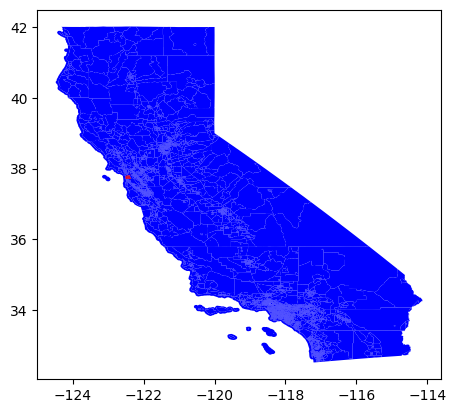

In [70]:
# open geo_polygons/new_york_city_council_2021.csv
geo_df = pd.read_csv("geo_polygons/san_francisco_city_council_2012.csv")
# rename geometry column to WKT
geo_df = geo_df.rename(columns={"geometry": "WKT"})
# convert to geodataframe
geo_df = gpd.GeoDataFrame(geo_df, geometry=gpd.GeoSeries.from_wkt(geo_df['WKT']))

# open tract_polygons/new york_tracts_2020.csv
tract_df = pd.read_csv("tract_polygons/california_tracts_2010.csv")
# rename geometry column to WKT
tract_df = tract_df.rename(columns={"geometry": "WKT"})
# convert to geodataframe
tract_df = gpd.GeoDataFrame(tract_df, geometry=gpd.GeoSeries.from_wkt(tract_df['WKT']))

# display geometries on top of each other
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
tract_df.plot(ax=ax, color='blue')
geo_df.plot(ax=ax, color='red')
plt.show()
